In [0]:
from pyspark.sql.functions import col
data_BASE_DIR = "dbfs:/mnt/mids-w261/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))
# Airline Data    
df_flights1 = spark.read.parquet(f"dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data/")
# Weather data
df_weather1 = spark.read.parquet(f"dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data/")
# Stations data      
df_stations = spark.read.parquet(f"dbfs:/mnt/mids-w261/datasets_final_project_2022/stations_data/stations_with_neighbors.parquet/")
# OTPW
df_otpw = spark.read.parquet(f"dbfs:/FileStore/Group_4_3/Data/Pipeline_Output/OTPW_60M_PARQUET")

path,name,size,modificationTime
dbfs:/mnt/mids-w261/HW5/,HW5/,0,1753754692917
dbfs:/mnt/mids-w261/OTPW_12M/,OTPW_12M/,0,1753754692917
dbfs:/mnt/mids-w261/OTPW_1D_CSV/,OTPW_1D_CSV/,0,1753754692917
dbfs:/mnt/mids-w261/OTPW_36M/,OTPW_36M/,0,1753754692917
dbfs:/mnt/mids-w261/OTPW_3M/,OTPW_3M/,0,1753754692917
dbfs:/mnt/mids-w261/OTPW_3M_2015.csv,OTPW_3M_2015.csv,1500620247,1741625185000
dbfs:/mnt/mids-w261/OTPW_3M_2015_delta/,OTPW_3M_2015_delta/,0,1753754692917
dbfs:/mnt/mids-w261/OTPW_60M/,OTPW_60M/,0,1753754692917
dbfs:/mnt/mids-w261/OTPW_60M_Backup/,OTPW_60M_Backup/,0,1753754692917
dbfs:/mnt/mids-w261/airport-codes_csv.csv,airport-codes_csv.csv,6232459,1740508595000


In [0]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator

# Step 1: Create binary label column (1 = delayed > 15 min)
df_otpw_class = df_otpw.withColumn("DEP_DELAY_BIN", when(col("DEP_DELAY") > 15, 1).otherwise(0))

# Step 2: Define numeric input features
numeric_features = [
    'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_ELAPSED_TIME', 'DISTANCE',
    'ELEVATION', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlySeaLevelPressure',
    'HourlyVisibility', 'HourlyWindGustSpeed', 'HourlyWindSpeed',
    'ORIGIN_BETWEENNESS', 'ORIGIN_DEGREE', 'ORIGIN_CLOSENESS',
    'DEST_BETWEENNESS', 'DEST_DEGREE', 'DEST_CLOSENESS',
    'PREV_FLIGHT_FLAG', 'CRS_DEP_TIME_MINUTES', 'TIME_BETWEEN_ARR_AND_SCHEDULED_DEP',
    'PREV_DEP_DELAY', 'CRS_TIME_X_DIST', 'ELEV_X_TEMP',
    'UNIQUE_ORIGINS', 'NUM_WITHIN_100_MILES', 'HOLIDAY_WITHIN_3D',
    'used_days_so_far', 'calendar_days_so_far', 'tail_num_use'
]

# Step 3: Cast all to double
for col_name in numeric_features:
    df_otpw_class = df_otpw_class.withColumn(col_name, col(col_name).cast("double"))

# Step 4: Drop rows with nulls in features or label
df_otpw_class = df_otpw_class.dropna(subset=numeric_features + ["DEP_DELAY_BIN"])

# Step 5: Assemble and scale features
assembler = VectorAssembler(inputCols=numeric_features, outputCol="features_unscaled")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withMean=True, withStd=True)

# Step 6: Define MLP architecture
input_dim = len(numeric_features)
layers = [input_dim, 64, 32, 2]  # 2 output classes (binary)

# Step 7: MLP Classifier
mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="DEP_DELAY_BIN",
    predictionCol="prediction",
    layers=layers,
    maxIter=50,
    blockSize=128,
    seed=42
)

# Step 8: Build Pipeline
pipeline = Pipeline(stages=[assembler, scaler, mlp])

# Step 9: Train/test split
train, test = df_otpw_class.randomSplit([0.8, 0.2], seed=42)

# Step 10: Train model
model = pipeline.fit(train)

# Step 11: Predict
predictions = model.transform(test)

# === Evaluation Metrics ===
eval_accuracy = MulticlassClassificationEvaluator(labelCol="DEP_DELAY_BIN", predictionCol="prediction", metricName="accuracy")
eval_f1 = MulticlassClassificationEvaluator(labelCol="DEP_DELAY_BIN", predictionCol="prediction", metricName="f1")
eval_recall = MulticlassClassificationEvaluator(labelCol="DEP_DELAY_BIN", predictionCol="prediction", metricName="weightedRecall")

# MAE (using RegressionEvaluator — works with classification if treated as numeric)
eval_mae = RegressionEvaluator(labelCol="DEP_DELAY_BIN", predictionCol="prediction", metricName="mae")

# === Results ===
accuracy = eval_accuracy.evaluate(predictions)
f1 = eval_f1.evaluate(predictions)
recall = eval_recall.evaluate(predictions)
mae = eval_mae.evaluate(predictions)

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"🎯 F1 Score: {f1:.4f}")
print(f"🔁 Recall: {recall:.4f}")
print(f"📉 MAE: {mae:.4f}")


✅ Accuracy: 0.8936
🎯 F1 Score: 0.8464
🔁 Recall: 0.8936
📉 MAE: 0.1064


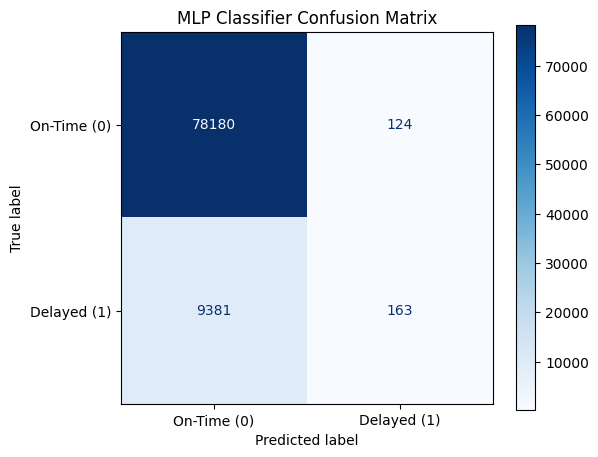

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Collect predictions and labels to Pandas
preds_pd = predictions.select("DEP_DELAY_BIN", "prediction").toPandas()

# Build confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(preds_pd["DEP_DELAY_BIN"], preds_pd["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["On-Time (0)", "Delayed (1)"])

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax)
plt.title("MLP Classifier Confusion Matrix")
plt.grid(False)
plt.show()


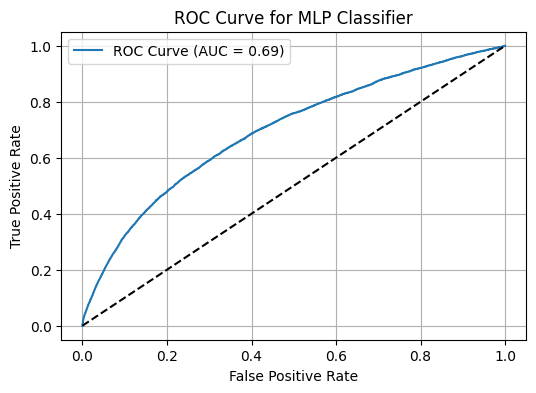

In [0]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Only possible if using probabilityCol from another classifier like LogisticRegression
preds_proba = predictions.select("DEP_DELAY_BIN", "probability").toPandas()
preds_proba["proba_delayed"] = preds_proba["probability"].apply(lambda x: x[1])

# ROC Curve
fpr, tpr, _ = roc_curve(preds_proba["DEP_DELAY_BIN"], preds_proba["proba_delayed"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for MLP Classifier")
plt.legend()
plt.grid(True)
plt.show()


# Extra Credit For Deep Learning (Keras on Subset bc Entire DF Will cause it to Crash)

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Recall, Precision

# Step 1: Sample and collect a manageable subset
sampled_df = df_otpw.select(numeric_features + ["DEP_DELAY"]).dropna().sample(fraction=0.01, seed=42)
pandas_df = sampled_df.toPandas()

# Step 2: Convert all numeric features and DEP_DELAY to numeric (handle 'T', '', etc.)
for col_name in numeric_features + ["DEP_DELAY"]:
    pandas_df[col_name] = pd.to_numeric(pandas_df[col_name], errors='coerce')

# Step 3: Drop rows with any NaNs in features or target
pandas_df = pandas_df.dropna(subset=numeric_features + ["DEP_DELAY"])

# Step 4: Create binary classification target
pandas_df["DEP_DELAY_BIN"] = (pandas_df["DEP_DELAY"] > 15).astype(int)


# Step 5: Prepare features and labels
X = pandas_df[numeric_features].values
y = pandas_df["DEP_DELAY_BIN"].values

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 7: Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 8: Define Keras MLP model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(), Precision()]
)

# Step 9: Train model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Step 10: Evaluate model
results = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy:  {results[1]:.4f}")
print(f"🔁 Test Recall:    {results[2]:.4f}")
print(f"🎯 Test Precision: {results[3]:.4f}")


/databricks/python/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8924 - loss: 0.3840 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8911 - val_loss: 0.3365 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9013 - loss: 0.3016 - precision: 0.3478 - recall: 0.0024 - val_accuracy: 0.8925 - val_loss: 0.3267 - val_precision: 1.0000 - val_recall: 0.0130
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8894 - loss: 0.3167 - precision: 0.3266 - recall: 0.0082 - val_accuracy: 0.8953 - val_loss: 0.3252 - val_precision: 1.0000 - val_recall: 0.0390
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8976 - loss: 0.2924 - precision: 0.4301 - recall: 0.0114 - val_accuracy: 0.8939 - val_loss: 0.3243 - val_precision: 0.7500 - val_recall: 0.0390
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9050 - loss: 0.2779 - precision: 0.8576 - recall: 0.0575 - val_accuracy: 0.8925 - val_l

#Imbalance in Delays 

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample, class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Recall, Precision

# Replace this with your actual sampled and cleaned DataFrame
# pandas_df = your_clean_sampled_dataframe

# Step 1: Convert all columns to numeric again (defensive)
for col_name in numeric_features + ["DEP_DELAY"]:
    pandas_df[col_name] = pd.to_numeric(pandas_df[col_name], errors='coerce')
pandas_df = pandas_df.dropna(subset=numeric_features + ["DEP_DELAY"])
pandas_df["DEP_DELAY_BIN"] = (pandas_df["DEP_DELAY"] > 15).astype(int)

# ========== Method 1: Downsampling ==========
df_majority = pandas_df[pandas_df.DEP_DELAY_BIN == 0]
df_minority = pandas_df[pandas_df.DEP_DELAY_BIN == 1]

df_majority_downsampled = resample(
    df_majority, replace=False, n_samples=len(df_minority), random_state=42
)
df_balanced = pd.concat([df_majority_downsampled, df_minority])

X_bal = df_balanced[numeric_features].values
y_bal = df_balanced["DEP_DELAY_BIN"].values

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

scaler_bal = StandardScaler()
X_train_bal = scaler_bal.fit_transform(X_train_bal)
X_test_bal = scaler_bal.transform(X_test_bal)

model_bal = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_bal.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_bal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(), Precision()])
model_bal.fit(X_train_bal, y_train_bal, epochs=10, batch_size=64, validation_split=0.2)
results_bal = model_bal.evaluate(X_test_bal, y_test_bal)

# ========== Method 2: Class Weights ==========
X = pandas_df[numeric_features].values
y = pandas_df["DEP_DELAY_BIN"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(cw))

model_cw = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_cw.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(), Precision()])
model_cw.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, class_weight=class_weight_dict)
results_cw = model_cw.evaluate(X_test, y_test)

# ========== Compare Results ==========
print("\n📊 Comparison of Methods")
print(f"Method: Downsampling")
print(f" - Accuracy:  {results_bal[1]:.4f}")
print(f" - Recall:    {results_bal[2]:.4f}")
print(f" - Precision: {results_bal[3]:.4f}")

print(f"\nMethod: Class Weights")
print(f" - Accuracy:  {results_cw[1]:.4f}")
print(f" - Recall:    {results_cw[2]:.4f}")
print(f" - Precision: {results_cw[3]:.4f}")


/databricks/python/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5104 - loss: 0.7358 - precision_1: 0.4993 - recall_1: 0.7723 - val_accuracy: 0.5685 - val_loss: 0.6655 - val_precision_1: 0.5455 - val_recall_1: 0.7500
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5769 - loss: 0.6752 - precision_1: 0.5918 - recall_1: 0.6488 - val_accuracy: 0.6164 - val_loss: 0.6577 - val_precision_1: 0.5833 - val_recall_1: 0.7778
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5572 - loss: 0.6724 - precision_1: 0.5591 - recall_1: 0.6145 - val_accuracy: 0.6233 - val_loss: 0.6529 - val_precision_1: 0.5914 - val_recall_1: 0.7639
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6423 - loss: 0.6466 - precision_1: 0.6322 - recall_1: 0.6728 - val_accuracy: 0.5616 - val_loss: 0.6596 - val_precision_1: 0.5377 - val_recall_1: 0.7917
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6381 - loss: 0.6368 - precision_1: 0.6406 - recall_1: 0.7211 - val_accu

/databricks/python/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7710 - loss: 0.7407 - precision_2: 0.0911 - recall_2: 0.1522 - val_accuracy: 0.5050 - val_loss: 0.7225 - val_precision_2: 0.1340 - val_recall_2: 0.6494
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5784 - loss: 0.6468 - precision_2: 0.1355 - recall_2: 0.6123 - val_accuracy: 0.6139 - val_loss: 0.6765 - val_precision_2: 0.1573 - val_recall_2: 0.5844
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6718 - loss: 0.6246 - precision_2: 0.1781 - recall_2: 0.6321 - val_accuracy: 0.6450 - val_loss: 0.6573 - val_precision_2: 0.1679 - val_recall_2: 0.5714
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7135 - loss: 0.6102 - precision_2: 0.1953 - recall_2: 0.6055 - val_accuracy: 0.6676 - val_loss: 0.6415 - val_precision_2: 0.1762 - val_recall_2: 0.5584
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7356 - loss: 0.6030 - precision_2: 0.2165 - recall_2: 0.5993 - val_accu

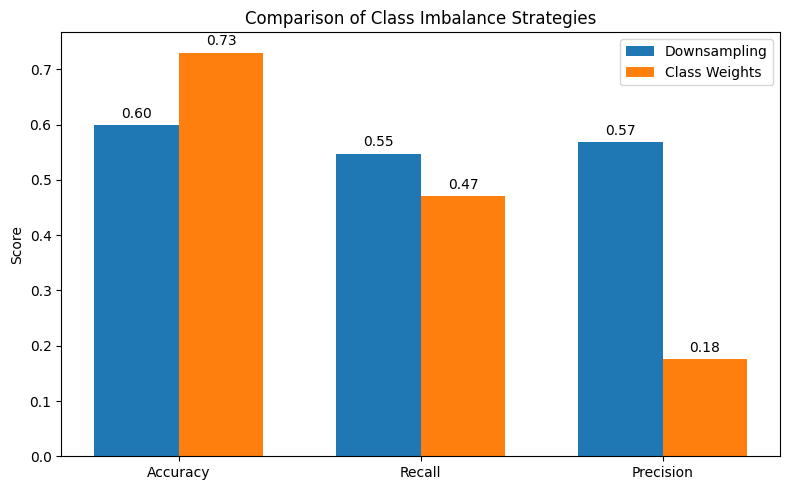

In [0]:
import matplotlib.pyplot as plt

# Define metrics
metrics = ['Accuracy', 'Recall', 'Precision']
downsampling_scores = [results_bal[1], results_bal[2], results_bal[3]]
class_weight_scores = [results_cw[1], results_cw[2], results_cw[3]]

# Bar chart setup
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, downsampling_scores, width, label='Downsampling')
bars2 = ax.bar(x + width/2, class_weight_scores, width, label='Class Weights')

# Labels and title
ax.set_ylabel('Score')
ax.set_title('Comparison of Class Imbalance Strategies')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Show value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Adding Hidden Layer to Original MLP

In [0]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator

# Step 1: Create binary label column (1 = delayed > 15 min)
df_otpw_class = df_otpw.withColumn("DEP_DELAY_BIN", when(col("DEP_DELAY") > 15, 1).otherwise(0))

# Step 2: Define numeric input features
numeric_features = [
    'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_ELAPSED_TIME', 'DISTANCE',
    'ELEVATION', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlySeaLevelPressure',
    'HourlyVisibility', 'HourlyWindGustSpeed', 'HourlyWindSpeed',
    'ORIGIN_BETWEENNESS', 'ORIGIN_DEGREE', 'ORIGIN_CLOSENESS',
    'DEST_BETWEENNESS', 'DEST_DEGREE', 'DEST_CLOSENESS',
    'PREV_FLIGHT_FLAG', 'CRS_DEP_TIME_MINUTES', 'TIME_BETWEEN_ARR_AND_SCHEDULED_DEP',
    'PREV_DEP_DELAY', 'CRS_TIME_X_DIST', 'ELEV_X_TEMP',
    'UNIQUE_ORIGINS', 'NUM_WITHIN_100_MILES', 'HOLIDAY_WITHIN_3D',
    'used_days_so_far', 'calendar_days_so_far', 'tail_num_use'
]

# Step 3: Cast all to double
for col_name in numeric_features:
    df_otpw_class = df_otpw_class.withColumn(col_name, col(col_name).cast("double"))

# Step 4: Drop rows with nulls in features or label
df_otpw_class = df_otpw_class.dropna(subset=numeric_features + ["DEP_DELAY_BIN"])

# Step 5: Assemble and scale features
assembler = VectorAssembler(inputCols=numeric_features, outputCol="features_unscaled")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withMean=True, withStd=True)

# Step 6: Define MLP architecture with an added hidden layer
input_dim = len(numeric_features)
layers = [input_dim, 128, 64, 32, 2]  # added 128-unit layer

# Step 7: MLP Classifier
mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="DEP_DELAY_BIN",
    predictionCol="prediction",
    layers=layers,
    maxIter=50,
    blockSize=128,
    seed=42
)

# Step 8: Build Pipeline
pipeline = Pipeline(stages=[assembler, scaler, mlp])

# Step 9: Train/test split
train, test = df_otpw_class.randomSplit([0.8, 0.2], seed=42)

# Step 10: Train model
model = pipeline.fit(train)

# Step 11: Predict
predictions = model.transform(test)

# === Evaluation Metrics ===
eval_accuracy = MulticlassClassificationEvaluator(labelCol="DEP_DELAY_BIN", predictionCol="prediction", metricName="accuracy")
eval_f1 = MulticlassClassificationEvaluator(labelCol="DEP_DELAY_BIN", predictionCol="prediction", metricName="f1")
eval_recall = MulticlassClassificationEvaluator(labelCol="DEP_DELAY_BIN", predictionCol="prediction", metricName="weightedRecall")
eval_mae = RegressionEvaluator(labelCol="DEP_DELAY_BIN", predictionCol="prediction", metricName="mae")

# === Results ===
accuracy = eval_accuracy.evaluate(predictions)
f1 = eval_f1.evaluate(predictions)
recall = eval_recall.evaluate(predictions)
mae = eval_mae.evaluate(predictions)

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"🎯 F1 Score: {f1:.4f}")
print(f"🔁 Recall: {recall:.4f}")
print(f"📉 MAE: {mae:.4f}")


✅ Accuracy: 0.8934
🎯 F1 Score: 0.8459
🔁 Recall: 0.8934
📉 MAE: 0.1066


# Loop Through Different MLP Architectures and Identify Optimal Config

In [0]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator

# Step 1: Binary label
df_otpw_class = df_otpw.withColumn("DEP_DELAY_BIN", when(col("DEP_DELAY") > 15, 1).otherwise(0))

# Step 2: Define numeric features
numeric_features = [
    'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_ELAPSED_TIME', 'DISTANCE',
    'ELEVATION', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlySeaLevelPressure',
    'HourlyVisibility', 'HourlyWindGustSpeed', 'HourlyWindSpeed',
    'ORIGIN_BETWEENNESS', 'ORIGIN_DEGREE', 'ORIGIN_CLOSENESS',
    'DEST_BETWEENNESS', 'DEST_DEGREE', 'DEST_CLOSENESS',
    'PREV_FLIGHT_FLAG', 'CRS_DEP_TIME_MINUTES', 'TIME_BETWEEN_ARR_AND_SCHEDULED_DEP',
    'PREV_DEP_DELAY', 'CRS_TIME_X_DIST', 'ELEV_X_TEMP',
    'UNIQUE_ORIGINS', 'NUM_WITHIN_100_MILES', 'HOLIDAY_WITHIN_3D',
    'used_days_so_far', 'calendar_days_so_far', 'tail_num_use'
]

# Step 3: Cast all to double
for col_name in numeric_features:
    df_otpw_class = df_otpw_class.withColumn(col_name, col(col_name).cast("double"))

df_otpw_class = df_otpw_class.dropna(subset=numeric_features + ["DEP_DELAY_BIN"])

# Step 4: Assemble and scale features
assembler = VectorAssembler(inputCols=numeric_features, outputCol="features_unscaled")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withMean=True, withStd=True)

# Step 5: Train/test split
train, test = df_otpw_class.randomSplit([0.8, 0.2], seed=42)

# Step 6: Define architectures to test
input_dim = len(numeric_features)
architectures = [
    [input_dim, 64, 32, 2],
    [input_dim, 128, 64, 32, 2],
    [input_dim, 256, 128, 64, 2],
    [input_dim, 64, 64, 32, 2],
    [input_dim, 128, 128, 64, 32, 2]
]

# Step 7: Evaluators
eval_accuracy = MulticlassClassificationEvaluator(labelCol="DEP_DELAY_BIN", predictionCol="prediction", metricName="accuracy")
eval_f1 = MulticlassClassificationEvaluator(labelCol="DEP_DELAY_BIN", predictionCol="prediction", metricName="f1")
eval_recall = MulticlassClassificationEvaluator(labelCol="DEP_DELAY_BIN", predictionCol="prediction", metricName="weightedRecall")
eval_mae = RegressionEvaluator(labelCol="DEP_DELAY_BIN", predictionCol="prediction", metricName="mae")

# Step 8: Loop through architectures
results = []
for i, layers in enumerate(architectures, 1):
    print(f"\n🚀 Training MLP Model {i} with layers: {layers}")
    mlp = MultilayerPerceptronClassifier(
        featuresCol="features",
        labelCol="DEP_DELAY_BIN",
        predictionCol="prediction",
        layers=layers,
        maxIter=100,
        blockSize=128,
        seed=42
    )
    pipeline = Pipeline(stages=[assembler, scaler, mlp])
    model = pipeline.fit(train)
    predictions = model.transform(test)
    
    accuracy = eval_accuracy.evaluate(predictions)
    f1 = eval_f1.evaluate(predictions)
    recall = eval_recall.evaluate(predictions)
    mae = eval_mae.evaluate(predictions)
    
    results.append((layers, accuracy, f1, recall, mae))
    print(f"✅ Accuracy: {accuracy:.4f}, 🎯 F1: {f1:.4f}, 🔁 Recall: {recall:.4f}, 📉 MAE: {mae:.4f}")

# Step 9: Display summary
print("\n📊 Summary of MLP Architectures:")
for i, (layers, accuracy, f1, recall, mae) in enumerate(results, 1):
    print(f"Model {i}: Layers={layers}")
    print(f" - Accuracy:  {accuracy:.4f}")
    print(f" - F1 Score:  {f1:.4f}")
    print(f" - Recall:    {recall:.4f}")
    print(f" - MAE:       {mae:.4f}")
    print("-" * 50)



🚀 Training MLP Model 1 with layers: [31, 64, 32, 2]
✅ Accuracy: 0.8939, 🎯 F1: 0.8478, 🔁 Recall: 0.8939, 📉 MAE: 0.1061

🚀 Training MLP Model 2 with layers: [31, 128, 64, 32, 2]
✅ Accuracy: 0.8941, 🎯 F1: 0.8472, 🔁 Recall: 0.8941, 📉 MAE: 0.1059

🚀 Training MLP Model 3 with layers: [31, 256, 128, 64, 2]
✅ Accuracy: 0.8943, 🎯 F1: 0.8476, 🔁 Recall: 0.8943, 📉 MAE: 0.1057

🚀 Training MLP Model 4 with layers: [31, 64, 64, 32, 2]
✅ Accuracy: 0.8939, 🎯 F1: 0.8472, 🔁 Recall: 0.8939, 📉 MAE: 0.1061

🚀 Training MLP Model 5 with layers: [31, 128, 128, 64, 32, 2]
✅ Accuracy: 0.8942, 🎯 F1: 0.8473, 🔁 Recall: 0.8942, 📉 MAE: 0.1058

📊 Summary of MLP Architectures:
Model 1: Layers=[31, 64, 32, 2]
 - Accuracy:  0.8939
 - F1 Score:  0.8478
 - Recall:    0.8939
 - MAE:       0.1061
--------------------------------------------------
Model 2: Layers=[31, 128, 64, 32, 2]
 - Accuracy:  0.8941
 - F1 Score:  0.8472
 - Recall:    0.8941
 - MAE:       0.1059
--------------------------------------------------
Model 3:

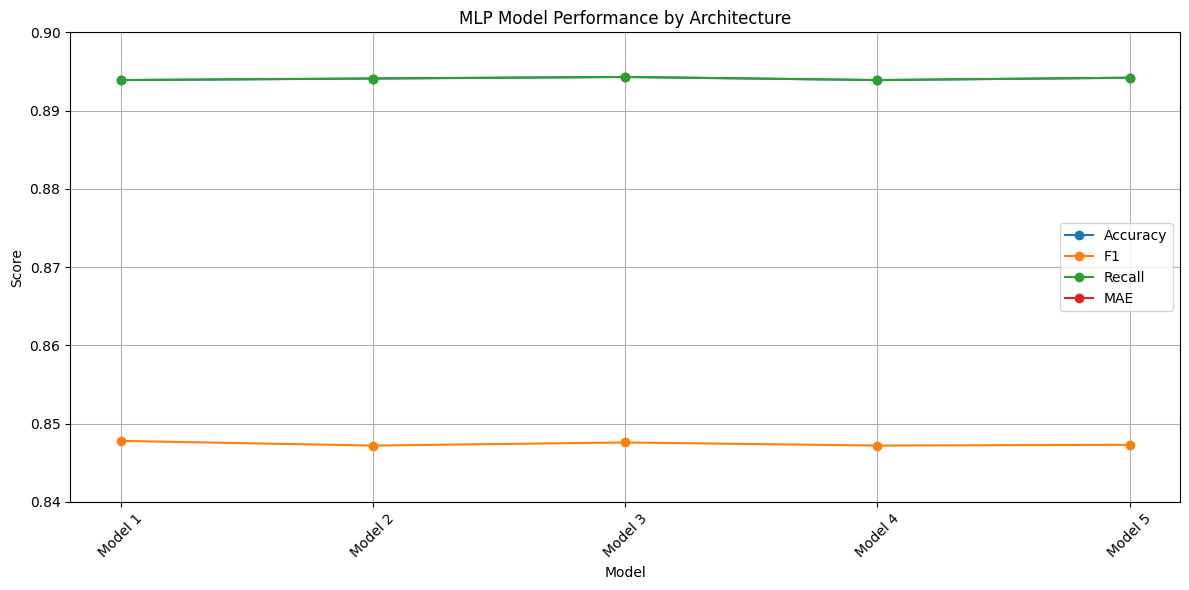

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define results manually (from your output)
results = [
    {"Model": "Model 1", "Layers": "[31, 64, 32, 2]", "Accuracy": 0.8939, "F1": 0.8478, "Recall": 0.8939, "MAE": 0.1061},
    {"Model": "Model 2", "Layers": "[31, 128, 64, 32, 2]", "Accuracy": 0.8941, "F1": 0.8472, "Recall": 0.8941, "MAE": 0.1059},
    {"Model": "Model 3", "Layers": "[31, 256, 128, 64, 2]", "Accuracy": 0.8943, "F1": 0.8476, "Recall": 0.8943, "MAE": 0.1057},
    {"Model": "Model 4", "Layers": "[31, 64, 64, 32, 2]", "Accuracy": 0.8939, "F1": 0.8472, "Recall": 0.8939, "MAE": 0.1061},
    {"Model": "Model 5", "Layers": "[31, 128, 128, 64, 32, 2]", "Accuracy": 0.8942, "F1": 0.8473, "Recall": 0.8942, "MAE": 0.1058}
]

df_results = pd.DataFrame(results)

# Step 2: Plot each metric
metrics = ["Accuracy", "F1", "Recall", "MAE"]
plt.figure(figsize=(12, 6))

for metric in metrics:
    plt.plot(df_results["Model"], df_results[metric], marker='o', label=metric)

plt.title("MLP Model Performance by Architecture")
plt.xlabel("Model")
plt.ylabel("Score")
plt.ylim(0.84, 0.90)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Metrics Arent Changing much. likely class imbalance and model is just predicting 'no delay'. basically the model is unable to predict any delays. not a legit model

In [0]:
from pyspark.sql.functions import col
conf_matrix = predictions.groupBy("DEP_DELAY_BIN", "prediction").count()
conf_matrix.show()


+-------------+----------+-----+
|DEP_DELAY_BIN|prediction|count|
+-------------+----------+-----+
|            1|       0.0| 9263|
|            0|       0.0|78260|
|            1|       1.0|  170|
|            0|       1.0|  109|
+-------------+----------+-----+



# upsample the minority class (dep_delay = 1) and use binaryclassificationevaluator for AUC and recall

In [0]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import DataFrame
import random

# Step 1: Label and feature prep
df_class = df_otpw.withColumn("DEP_DELAY_BIN", when(col("DEP_DELAY") > 15, 1).otherwise(0))

numeric_features = [
    'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_ELAPSED_TIME', 'DISTANCE',
    'ELEVATION', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlySeaLevelPressure',
    'HourlyVisibility', 'HourlyWindGustSpeed', 'HourlyWindSpeed',
    'ORIGIN_BETWEENNESS', 'ORIGIN_DEGREE', 'ORIGIN_CLOSENESS',
    'DEST_BETWEENNESS', 'DEST_DEGREE', 'DEST_CLOSENESS',
    'PREV_FLIGHT_FLAG', 'CRS_DEP_TIME_MINUTES', 'TIME_BETWEEN_ARR_AND_SCHEDULED_DEP',
    'PREV_DEP_DELAY', 'CRS_TIME_X_DIST', 'ELEV_X_TEMP',
    'UNIQUE_ORIGINS', 'NUM_WITHIN_100_MILES', 'HOLIDAY_WITHIN_3D',
    'used_days_so_far', 'calendar_days_so_far', 'tail_num_use'
]

for col_name in numeric_features:
    df_class = df_class.withColumn(col_name, col(col_name).cast("double"))

df_class = df_class.dropna(subset=numeric_features + ["DEP_DELAY_BIN"])

# Step 2: Manual resampling (upsample class 1 to match class 0)
major = df_class.filter(col("DEP_DELAY_BIN") == 0)
minor = df_class.filter(col("DEP_DELAY_BIN") == 1)
ratio = major.count() // minor.count()
extra = major.count() % minor.count()

minor_upsampled = minor.unionAll(minor.sample(withReplacement=True, fraction=float(ratio), seed=42))
if extra > 0:
    minor_upsampled = minor_upsampled.unionAll(
        minor.sample(withReplacement=True, fraction=float(extra) / minor.count(), seed=42)
    )

df_balanced = major.unionAll(minor_upsampled)

# Step 3: VectorAssembler
assembler = VectorAssembler(inputCols=numeric_features, outputCol="features")

# Step 4: Random Forest Classifier
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="DEP_DELAY_BIN",
    predictionCol="prediction",
    numTrees=100,
    maxDepth=10,
    seed=42
)

# Step 5: Pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Step 6: Train-test split
train, test = df_balanced.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train)
predictions = model.transform(test)

# Step 7: Evaluation
evaluator_auc = BinaryClassificationEvaluator(labelCol="DEP_DELAY_BIN", metricName="areaUnderROC")
evaluator_recall = BinaryClassificationEvaluator(labelCol="DEP_DELAY_BIN", metricName="areaUnderPR")

auc = evaluator_auc.evaluate(predictions)
recall_pr = evaluator_recall.evaluate(predictions)

print(f"✅ ROC AUC: {auc:.4f}")
print(f"🎯 PR AUC (Recall-focused): {recall_pr:.4f}")

# Step 8: Confusion Matrix
conf_matrix = predictions.groupBy("DEP_DELAY_BIN", "prediction").count()
conf_matrix.show()


✅ ROC AUC: 0.7415
🎯 PR AUC (Recall-focused): 0.7656
+-------------+----------+-----+
|DEP_DELAY_BIN|prediction|count|
+-------------+----------+-----+
|            0|       0.0|55465|
|            0|       1.0|23088|
|            1|       0.0|30251|
|            1|       1.0|57450|
+-------------+----------+-----+

